In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
#print(os.listdir("../input"))
from os import path
# Any results you write to the current directory are saved as output.

['test.csv', 'test', 'sample_submission', 'train', 'train.csv', 'sample_submission.csv']


## Data loading

In [3]:
# Load the data train
TRAIN_PATH = path.join('..', 'input','train.csv')
df = pd.read_csv(TRAIN_PATH)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
# Load the data test
TRAIN_PATH = path.join('..', 'input','test.csv')
df_test = pd.read_csv(TRAIN_PATH)
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
# Load the data submission
SUBMIT_PATH = path.join('..', 'input','sample_submission.csv')
df_submission = pd.read_csv(SUBMIT_PATH)
df_submission.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


## Data exploration

### Global informations

In [6]:
# Show informations about all data
# df['store_and_fwd_flag'].nunique()
# df.shape
# df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### Count of passengers

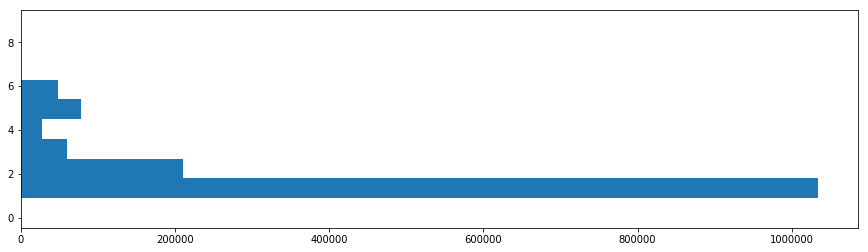

In [7]:
plt.figure(figsize=(15, 4))
plt.hist(x='passenger_count', data=df, orientation='horizontal');

We can see that between 1 and 6 there is no data. Indeed, there were courses which have been recorded with no passengers. Beside, a taximan can't take more than 4 passengers. We'll filter data passengers to get ride of that.

### Trip duration

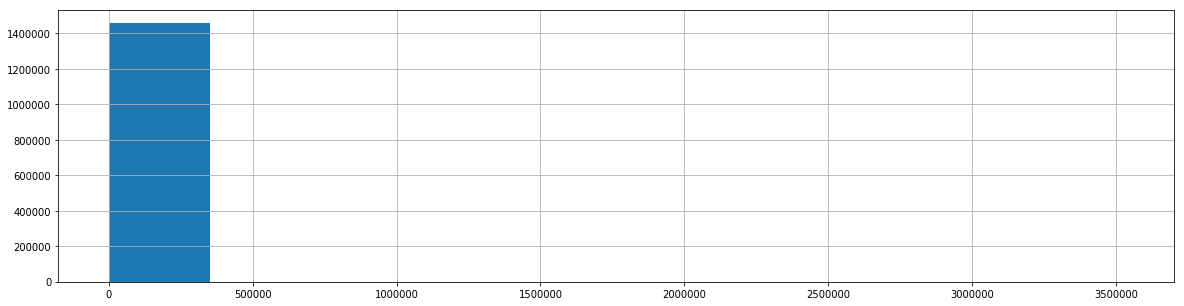

In [8]:
plt.figure(figsize=(20, 5))
df['trip_duration'].hist();

We can see above a large amount of trips which lasted for days because they are over 24 hours (= 86400 seconds). In fact, we'll filter data to see trips less than 2 hours (= 7200 seconds).

## Data processing

In [9]:
# change pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])

In [10]:
# encode store_and_fwd_flag column and add column to see if it's the night or not
def preprocess(df):
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_min'] = df['pickup_datetime'].dt.minute
    df['store_and_fwd_flag_codes'] = df['store_and_fwd_flag'].astype('category').cat.codes
    df['is_night'] = (df['pickup_hour'] > 18) & (df['pickup_hour'] < 7)
    
preprocess(df)
preprocess(df_test)

In [11]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_month,pickup_weekday,pickup_hour,pickup_min,store_and_fwd_flag_codes,is_night
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,0,17,24,0,False
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,6,0,43,0,False
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,1,11,35,0,False
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,2,19,32,0,False
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,5,13,30,0,False


In [12]:
# filter DF by remove rows with 0 passengers and trip duration over 7200 secs
filter_ = (df['passenger_count'] > 0) & (df['trip_duration'] < 7200)
df = df[filter_]
df.shape

(1456332, 18)

## Features engineering

### Config

In [13]:
TARGET = 'trip_duration'
FEATURES = df.columns.drop(['trip_duration','pickup_datetime', 'dropoff_datetime', 'id', 'store_and_fwd_flag'])

### Split

In [14]:
def split_dataset(df, features, target=TARGET):
    X = df[features]
    y = df[target]
    
    return X, y

In [24]:
X_train, y_train = split_dataset(df, features=FEATURES)
X_train.shape, y_train.shape

((1456332, 13), (1456332,))

## Modeling

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

rf = RandomForestRegressor()
kf = KFold(n_splits=5, random_state=1)

### Cross validation

In [17]:
rf.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
losses = cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_squared_log_error')
losses = [np.sqrt(-l) for l in losses]
np.mean(losses)

0.4614898283291608

## Prediction

In [19]:
# Re-instantiate RF for test and fit
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
X_test = df_test[FEATURES]

In [21]:
# test prediction
y_test_pred = rf.predict(X_test)
y_test_pred.mean()

844.6126432092959

## Submission

In [22]:
df_submission['trip_duration'] = y_test_pred
df_submission.head()

,id,trip_duration
0,id3004672,899.1
1,id3505355,683.5
2,id1217141,661.5
3,id2150126,1087.9
4,id1598245,526.1


In [23]:
# comparison
train_mean = df['trip_duration'].mean()
pred_mean = df_submission['trip_duration'].mean()
train_mean, pred_mean

(836.0969977999522, 844.6126432093074)

In [ ]:
df_submission.to_csv('submission.csv', index=False)